# 모델링 a

회귀분석(회귀선, 예측값, 잔차, 변수간의 상호관계), 변환, 결측값, 다른 모델

In [59]:
library('tidyverse')
library('modelr')

## 회귀분석

### 회귀선

- 회귀분석을 원초적으로부터 시작해보기<br>
일단 찍는다.

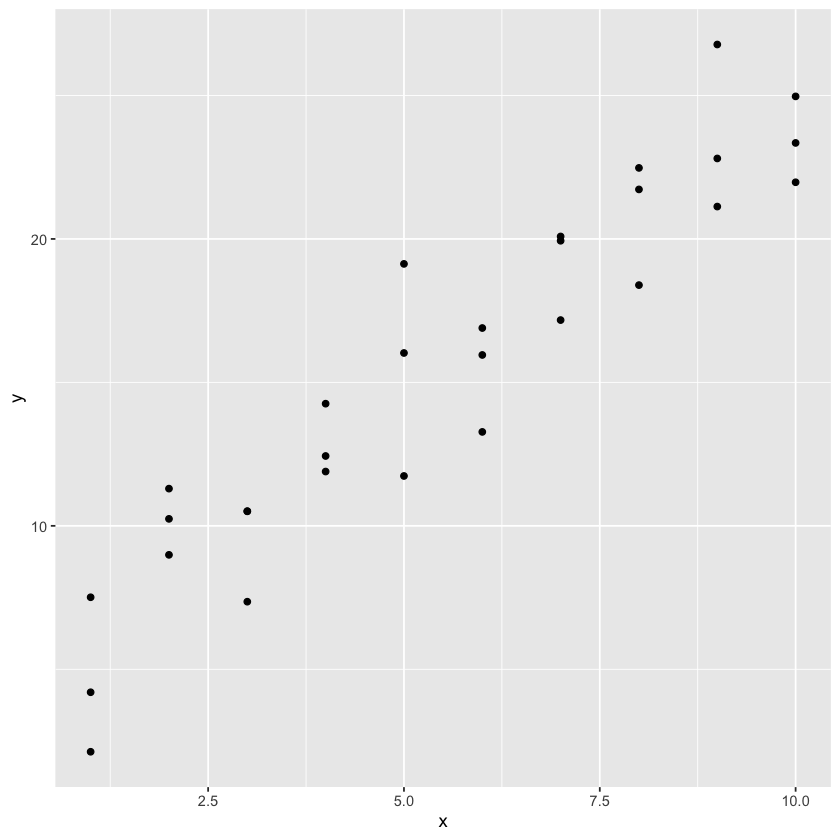

In [3]:
ggplot(sim1, aes(x, y)) +
geom_point()

`-` 250개의 점을 찍고 그 점들 각각을 $B_0$ 와 $B_1$으로 사용해서 선을 그은 모습

In [4]:
models <- tibble(
    a1 = runif(250, -20, 40),
    a2 = runif(250, -5, 5)
    )

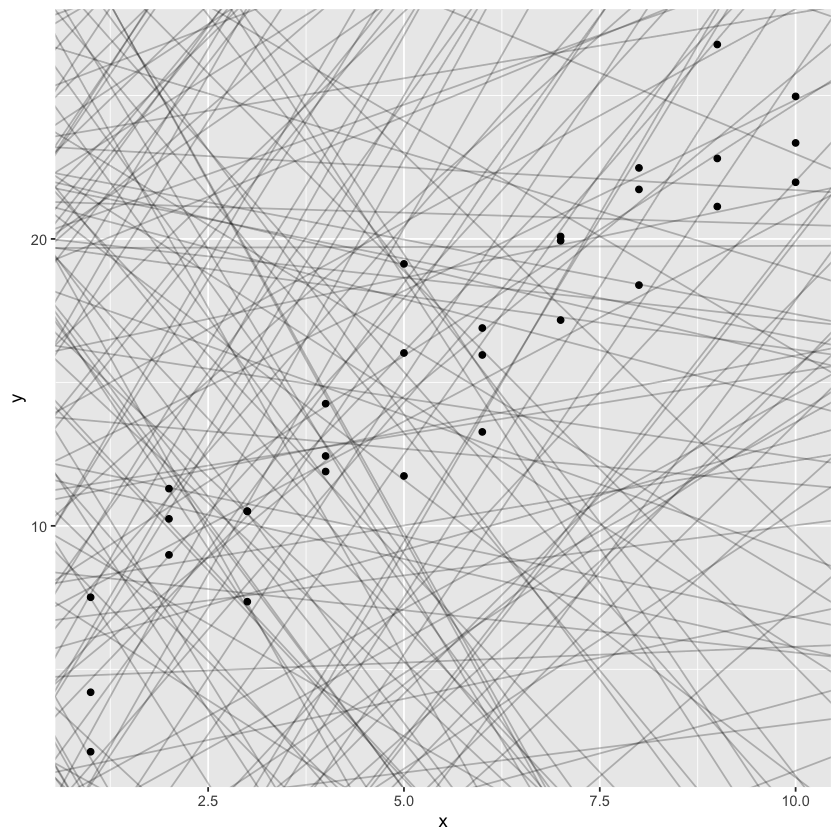

In [5]:
ggplot(sim1, aes(x, y)) +
geom_abline(
    aes(intercept = a1, slope = a2),
    data = models, alpha = 1/4
    ) +
geom_point()

`-` 점들에 회귀선 추가해서 그리기

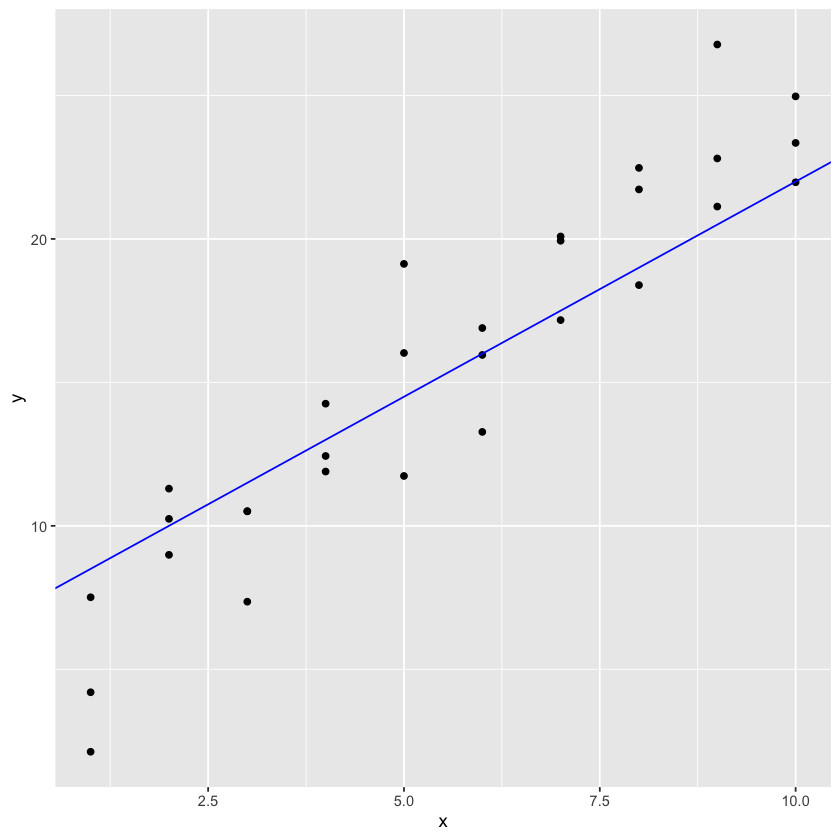

In [6]:
ggplot(sim1, aes(x, y)) +
geom_point() +
geom_abline(intercept = 7, slope = 1.5, color = "BLUE")

`-` 선을 250개 긋는 것은 정확한 방법이 아닌 것 같으므로 거리 기반으로 선을 긋기 위해 높이 파악(y값)<br>
기준은 위의 파란선으로부터

In [7]:
model1 <- function(a, data){
    a[1] + data$x * a[2]
    }
model1(c(7, 1.5), sim1)

[1]  8.5  8.5  8.5 10.0 10.0 10.0 11.5 11.5 11.5 13.0 13.0 13.0 14.5 14.5 14.5
[16] 16.0 16.0 16.0 17.5 17.5 17.5 19.0 19.0 19.0 20.5 20.5 20.5 22.0 22.0 22.0

`-` 평균 제곱근으로 거리 구하기(음의 거리 절댓값 씌워주기 위해)<br>
일단 한 개

In [8]:
measure_distance <- function(mod, data){
    diff <- data$y - model1(mod, data)
    sqrt(mean(diff^2))
    }

measure_distance(c(7, 1.5), sim1)

[1] 2.665212

`-` 이 방법을 위의 250개의 데이터 셋에 적용

In [9]:
sim1_dist <- function(a1, a2){
    measure_distance(c(a1, a2), sim1)
    }

models <- models %>%
mutate(dist = purrr::map2_dbl(a1, a2, sim1_dist))
models %>% head

a1,a2,dist
<dbl>,<dbl>,<dbl>
-8.247004,0.697756642,20.40099
-9.448927,2.427623209,11.84420
19.508571,-4.119477393,25.81913
-3.733276,4.821871493,10.99476
-1.019675,-0.000299504,17.67361
-2.200861,4.995275936,13.09397


`-` 이 방법으로 구한 회귀선을 점과 함께 그어보기<br>
가장 좋은 10개의 점의 선만 보이게 함

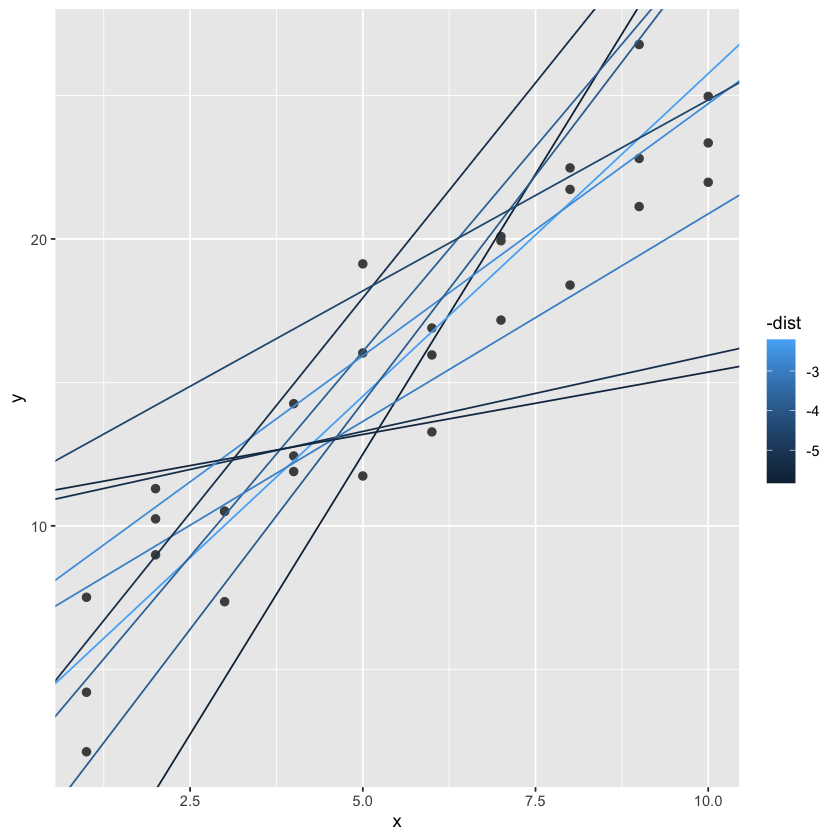

In [10]:
ggplot(sim1, aes(x, y)) +
geom_point(size = 2, color = "grey30") +
geom_abline(
    aes(intercept = a1, slope = a2, color = -dist),
    data = filter(models, rank(dist) <= 10)
    )

`-` 가장 좋은 10개의 점은 빨간 색으로 강조 표시<br>
나머지 250개 점도 이번에는 표기

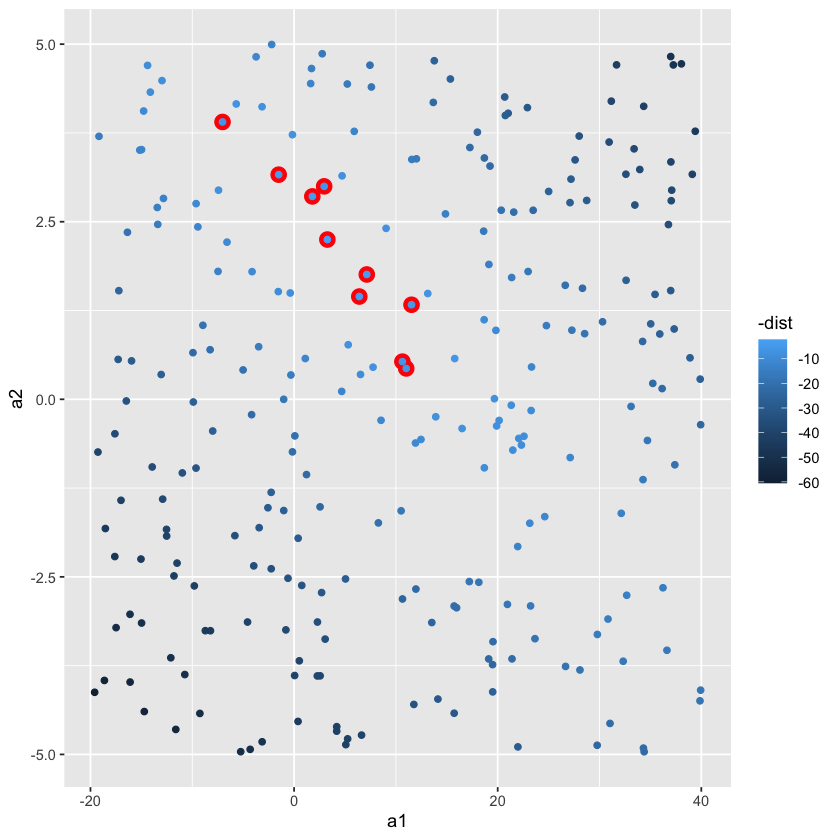

In [11]:
ggplot(models, aes(a1, a2)) +
geom_point(
    data = filter(models, rank(dist) <= 10),
    size = 4, color = "red"
    ) +
geom_point(aes(color = -dist))

`-` 골고루 뿌려진(실제 모습) 형태가 아닌 같은 간격의 균등한 격자무늬에 어느 포지션에 위치하나를 보고 싶다면 사용할 수 있는 방법<br>
이 방법을 grid search라 한다.

In [12]:
grid <- expand.grid(
    a1 = seq(-5, 20, length = 25),
    a2 = seq(1, 3, length = 25)
    ) %>%
mutate(dist = purrr::map2_dbl(a1, a2, sim1_dist))

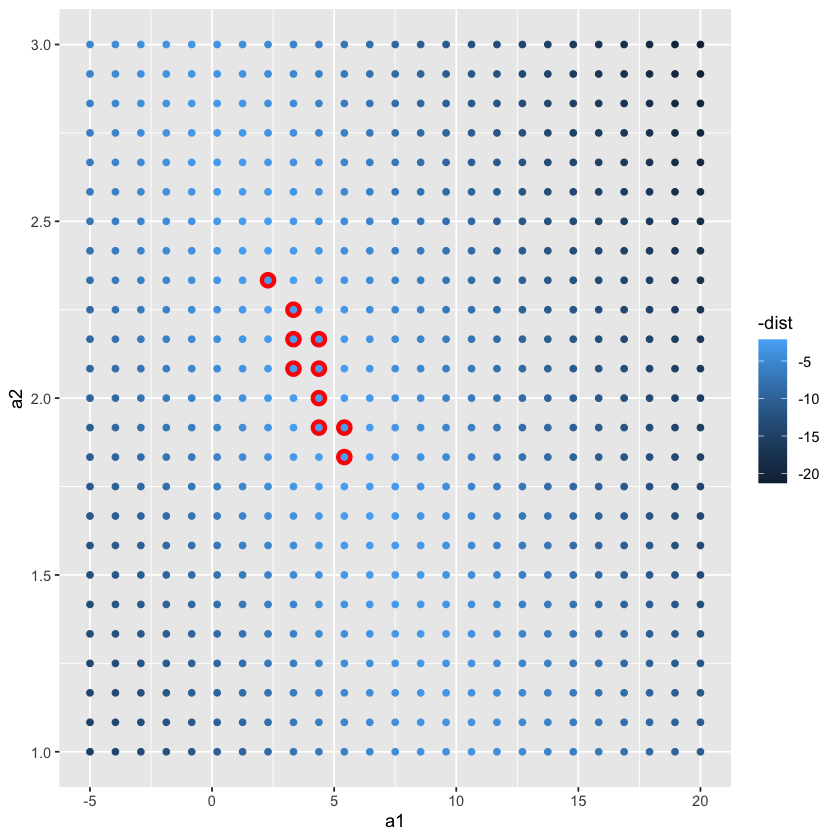

In [13]:
grid %>%
ggplot(aes(a1, a2)) +
geom_point(
    data = filter(grid, rank(dist) <= 10),
    size = 4, color = "red"
    ) +
geom_point(aes(color = -dist))

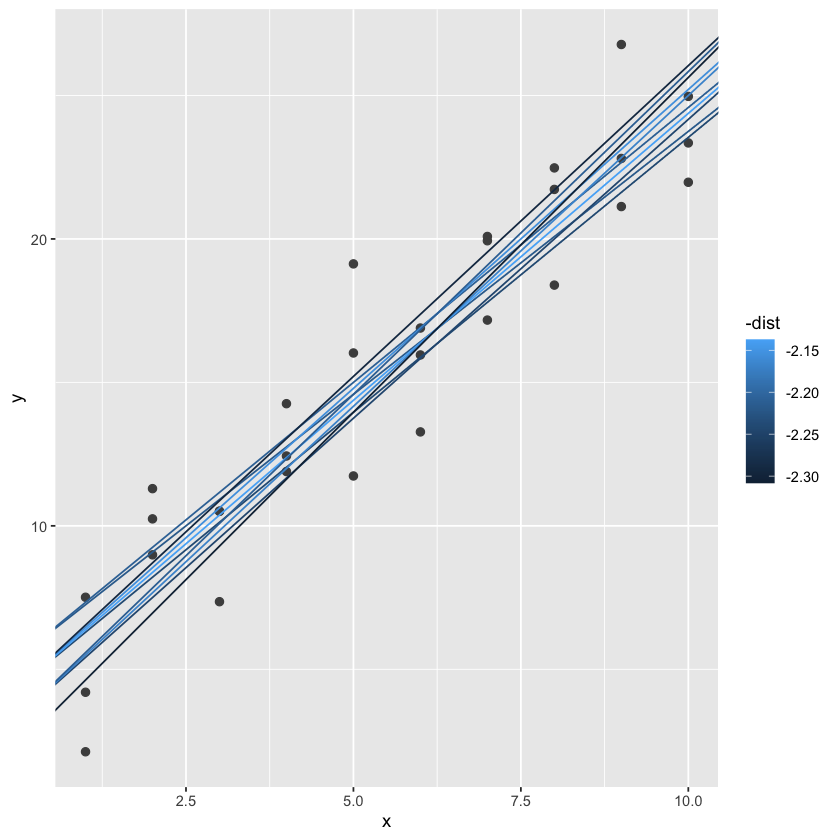

In [14]:
ggplot(sim1, aes(x, y)) +
geom_point(size = 2, color = "grey30") +
geom_abline(
    aes(intercept = a1, slope = a2, color = -dist),
    data = filter(grid, rank(dist) <= 10)
    )

최적의 모델을 선택할 때까지 그리드를 반복적으로 더욱 세밀하게 만드는 작업을 생각해볼 수 있다.<br>
하지만 이 문제를 해결할 수 있는 더 좋은 방법인 뉴턴 랩슨 기법(Newton-Raphson search)이라 불리는 수치 최소화 도구가 있다.<br>
뉴튼 랩슨 기법의 직관은 매우 간단하다. 시작점을 선택하고 가장 가파른 기울기를 찾기 위해 탐색한다. 그런 다음 가장 작은 값으로 갈 수 없을 때까지 기울기를 약간씩
기울이는 작업을 반복한다. R에서는 optim()을 사용하여 이 작업을 수행할 수 있다.

In [15]:
best <- optim(c(0, 0), measure_distance, data = sim1)
best$par

[1] 4.222248 2.051204

`optim` 기법을 이용해 얻은 회귀선

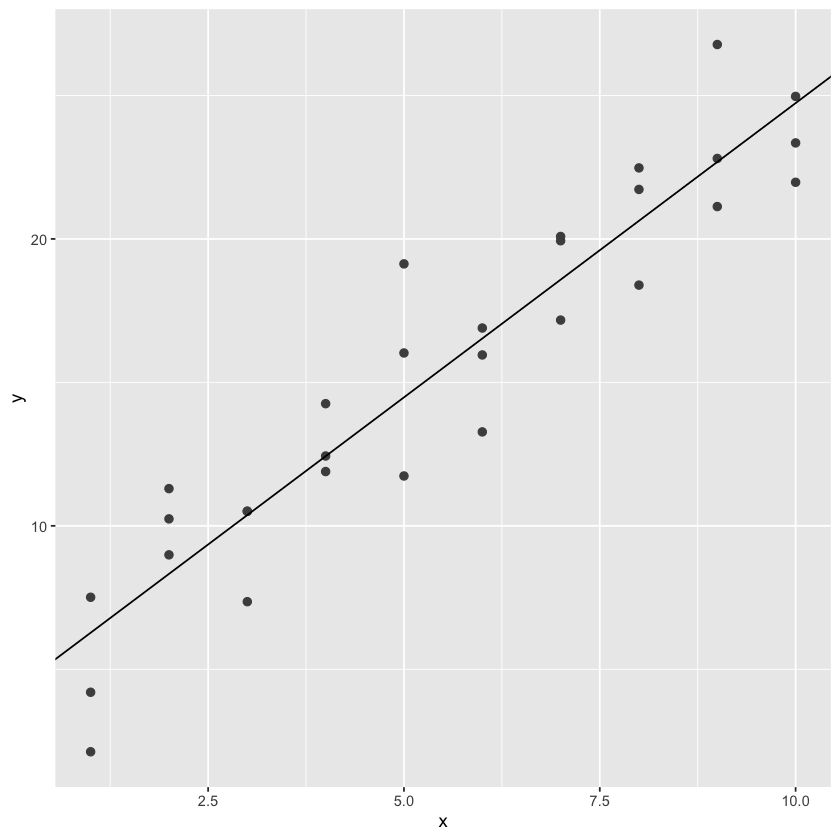

In [16]:
ggplot(sim1, aes(x, y)) +
geom_point(size = 2, color = "grey30") +
geom_abline(intercept = best$par[1], slope = best$par[2])

사실 이 방법이 lm에서 회귀선을 구해주는 방식이다.

In [17]:
sim1_mod <- lm(y ~ x, data = sim1)
coef(sim1_mod)

(Intercept)           x 
   4.220822    2.051533

### 예측값

`-` 예측값 만들어 실제와 비교해보기 위해 예측값을 생성하기

`data_grid` : 해당 항목의 값만 뽑아서 보기(중복 제외)

In [18]:
grid <- sim1 %>%
data_grid(x)

grid

x
<int>
1
2
3
4
5
6
7
8
9


In [19]:
grid <- grid %>%
add_predictions(sim1_mod)

grid

x,pred
<int>,<dbl>
1,6.272355
2,8.323888
3,10.375421
4,12.426954
5,14.478487
6,16.530020
7,18.581553
8,20.633087
9,22.684620


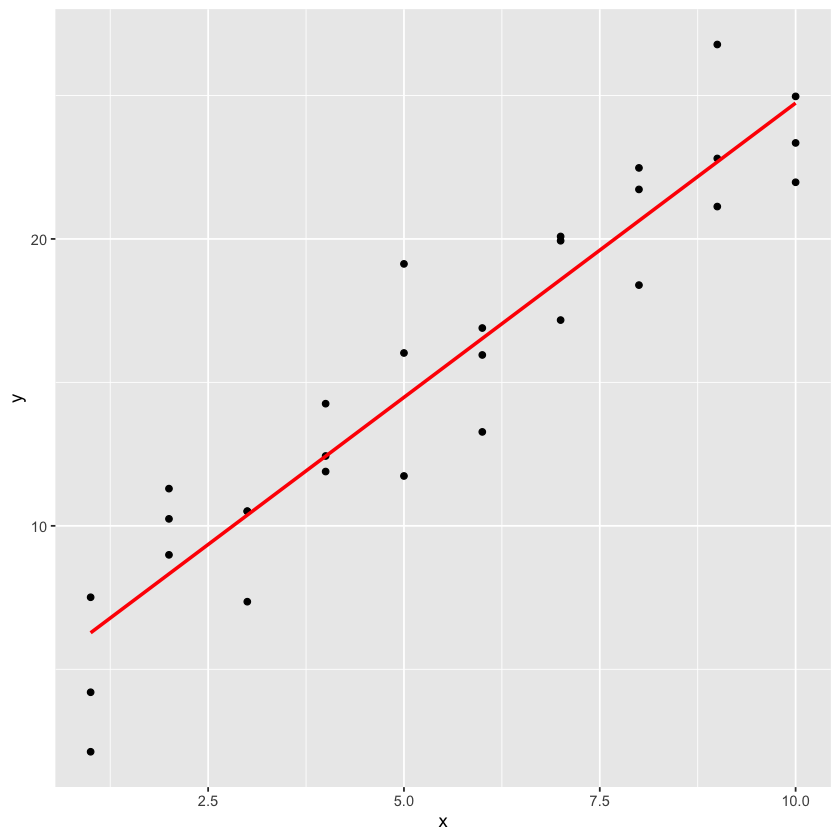

In [20]:
ggplot(sim1, aes(x)) +
geom_point(aes(y = y)) +
geom_line(
    aes(y = pred),
    data = grid,
    color = "red",
    size = 1
    )

### 잔차

In [21]:
sim1 <- sim1 %>%
add_residuals(sim1_mod)

In [22]:
sim1 %>% head

x,y,resid
<int>,<dbl>,<dbl>
1,4.199913,-2.0724420
1,7.510634,1.2382791
1,2.125473,-4.1468822
2,8.988857,0.6649694
2,10.243105,1.9192174
2,11.296823,2.9729351


`geom_freqpoly` : `ggplot`의 히스토그램 함수

`-` 잔차의 빈도

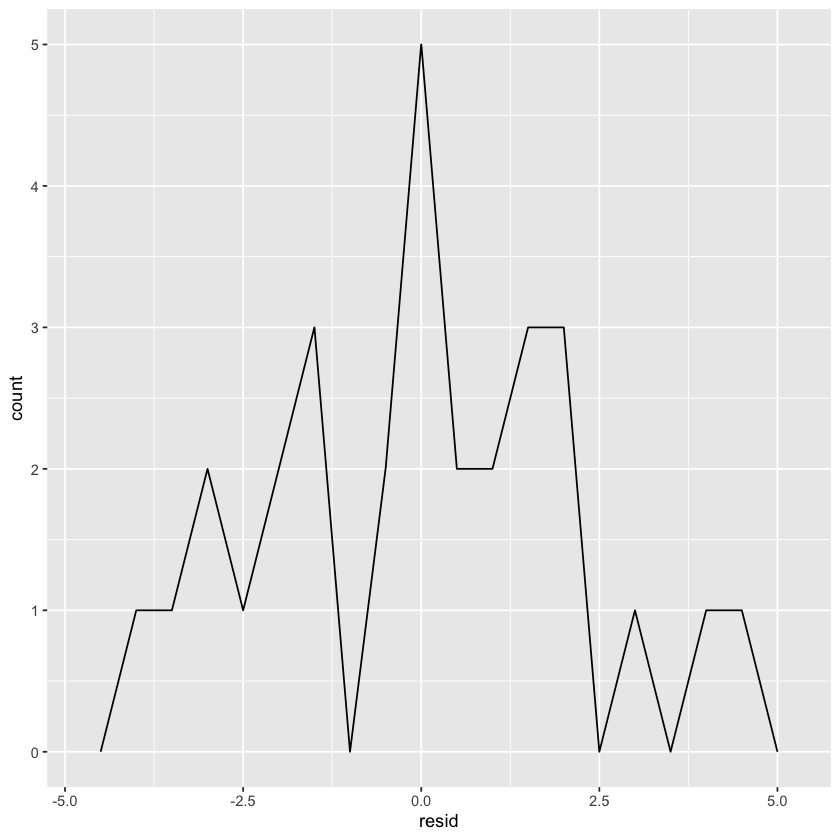

In [23]:
ggplot(sim1, aes(resid)) +
geom_freqpoly(binwidth = 0.5)

`geom_ref_line` : `ggplot`에 참조선 추가해준다.<br>
> geom_ref_line(h, v, 크기 = 2, 색상 = "흰색")

`-` 잔차의 분포<br>
랜덤하게 분포된 것을 보니 모델이 데이터셋에서 패턴을 잘 포착하였음을 의미한다. 

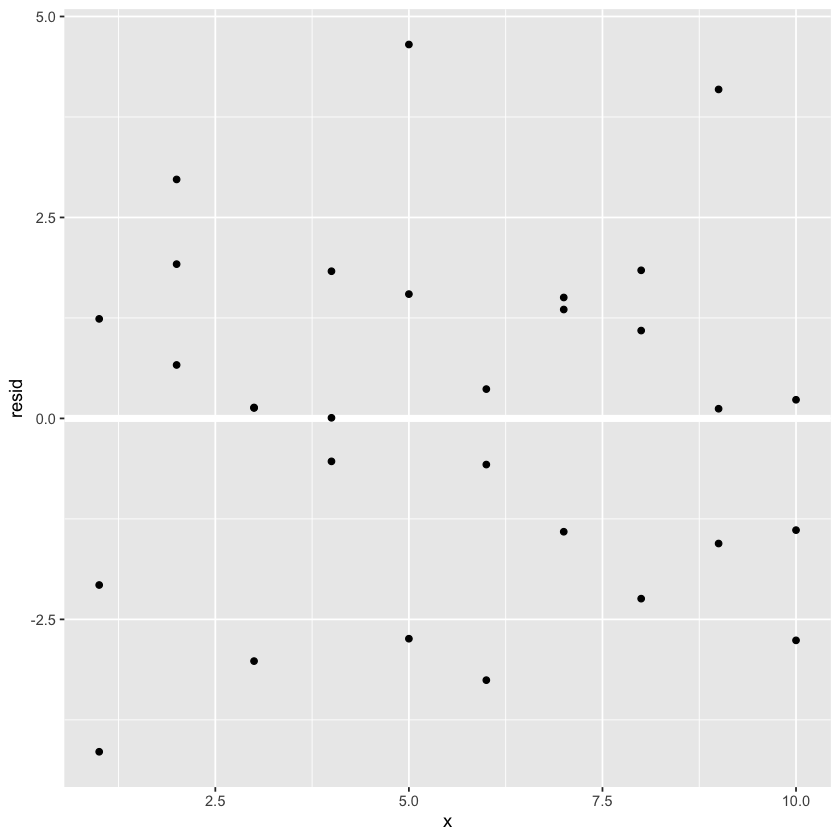

In [24]:
ggplot(sim1, aes(x, resid)) +
geom_ref_line(h = 0) +
geom_point()

`model_matrix` : 회귀모델을 matrix로 보여준다.<br>

In [25]:
df <- tribble(
    ~y, ~x1, ~x2,
    4,2,5,
    5,1,6
    )

model_matrix(df, y ~ x1)

(Intercept),x1
<dbl>,<dbl>
1,2
1,1


`-` 열 하나 줄이기

In [26]:
model_matrix(df, y ~ x1 - 1)

x1
<dbl>
2
1


`-` x2변수까지 추가

In [27]:
model_matrix(df, y ~ x1 + x2)

(Intercept),x1,x2
<dbl>,<dbl>,<dbl>
1,2,5
1,1,6


`-`범주형 변수에서의 `model_matrix`

In [28]:
df <- tribble(
    ~ sex, ~ response,
    "male", 1,
    "female", 2,
    "male", 1
    )

df

sex,response
<chr>,<dbl>
male,1
female,2
male,1


In [29]:
model_matrix(df, response ~ sex)

(Intercept),sexmale
<dbl>,<dbl>
1,1
1,0
1,1


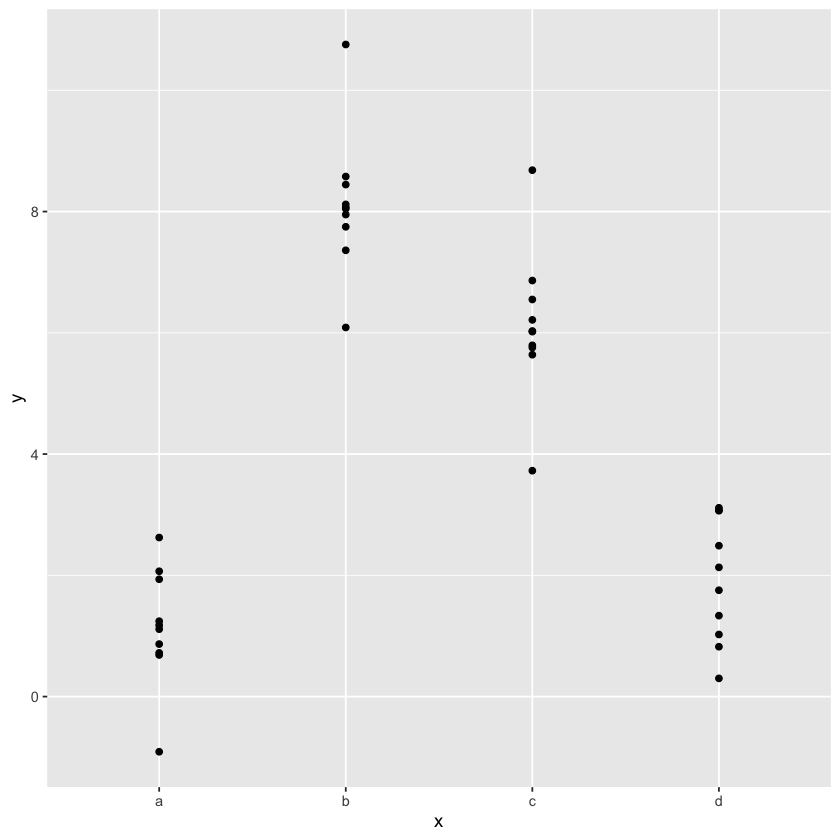

In [30]:
ggplot(sim2) +
geom_point(aes(x, y))

`add_predictions` : 해당 모델로 추정된 예측값 추가

In [31]:
mod2 <- lm(y ~ x, data = sim2)

grid <- sim2 %>%
data_grid(x) %>%
add_predictions(mod2)

grid

x,pred
<chr>,<dbl>
a,1.152166
b,8.116039
c,6.127191
d,1.910981


사실상 범주형 변수 x를 포함한 모델은 각 범주의 평균값을 예측한다.(그 이유는 각 범주의 평균값이 평균제곱근 편차를 최소화 하기 때문이다.)<br>
이는 원 데이터 위에 예측값을 겹쳐서 그려보면 쉽게 확인할 수 있다.

`-` "sim2" 데이터 셋에 예측값은 빨간 색으로 찍어 보았다.<br>
평균 정도 위치에 있음을 볼 수 있다.

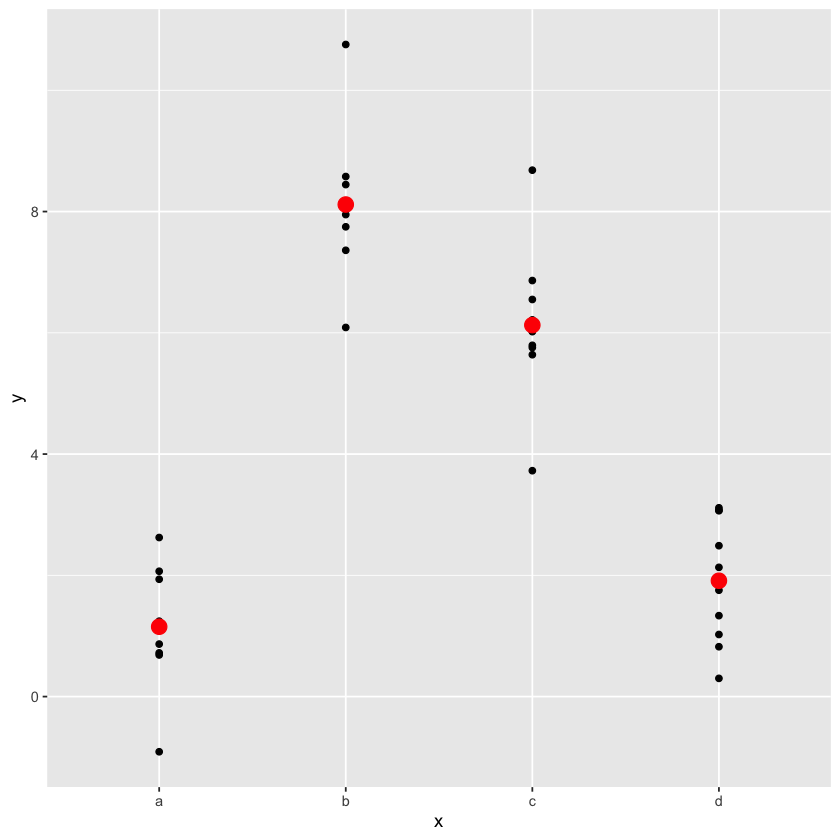

In [32]:
ggplot(sim2, aes(x)) +
geom_point(aes(y = y)) +
geom_point(
    data = grid,
    aes(y = pred),
    color = "red",
    size = 4
    )

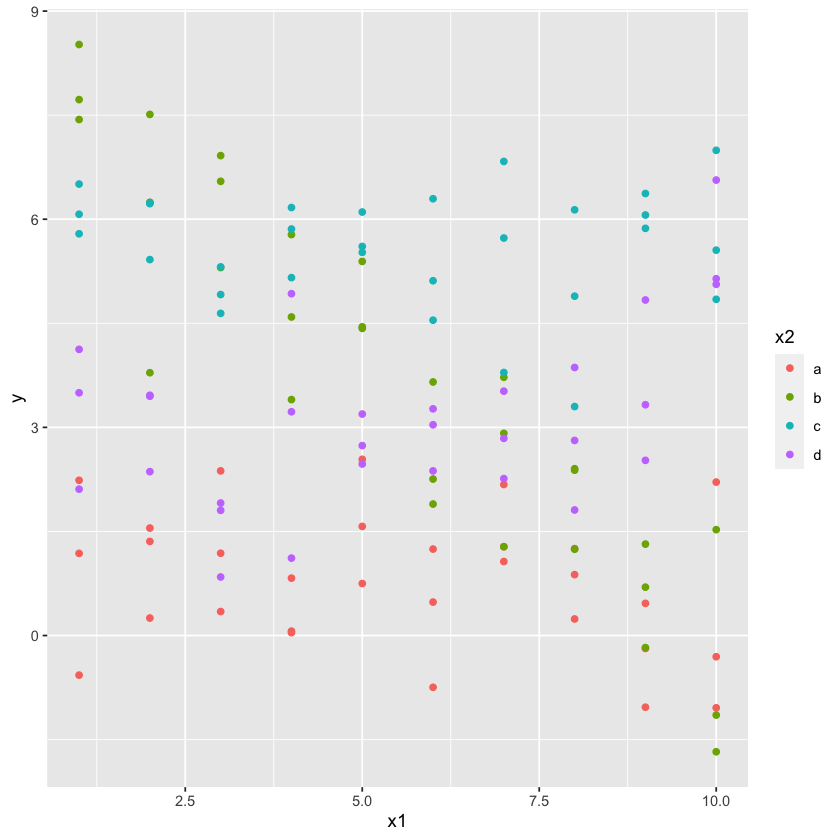

In [33]:
ggplot(sim3, aes(x1, y)) +
geom_point(aes(color = x2))

### 변수간의 상호작용 관계

`+`를 사용하여 변수를 추가하면 모델은 다른 모든 변수와 독립적인 각 효과를 추정한다.<br>
`*`을 사용하면 상호작용이라 불리는 항을 적합할 수 있다. 예를 들어<br>
$y$ ~ $x1 * x2$는<br>
$ y = a_0 + a_1 * a1 + a_2 * a2 + a_{12} * a1 * a2$로 변환된다.


`-` 이를 위해 두 가지 모델 사용<br>
각각은 변수를 `+`, `*` 관계로 적용

In [34]:
mod1 <- lm(y ~ x1 + x2, data = sim3)
mod2 <- lm(y ~ x1 * x2, data = sim3)

In [35]:
grid <- sim3 %>%
data_grid(x1, x2) %>%
gather_predictions(mod1, mod2)
grid %>% head

model,x1,x2,pred
<chr>,<int>,<fct>,<dbl>
mod1,1,a,1.674928
mod1,1,b,4.562739
mod1,1,c,6.480664
mod1,1,d,4.034515
mod1,2,a,1.478190
mod1,2,b,4.366001


`facet_wrap` : 그룹별(범주)로 plot을 분할하여 보여준다.

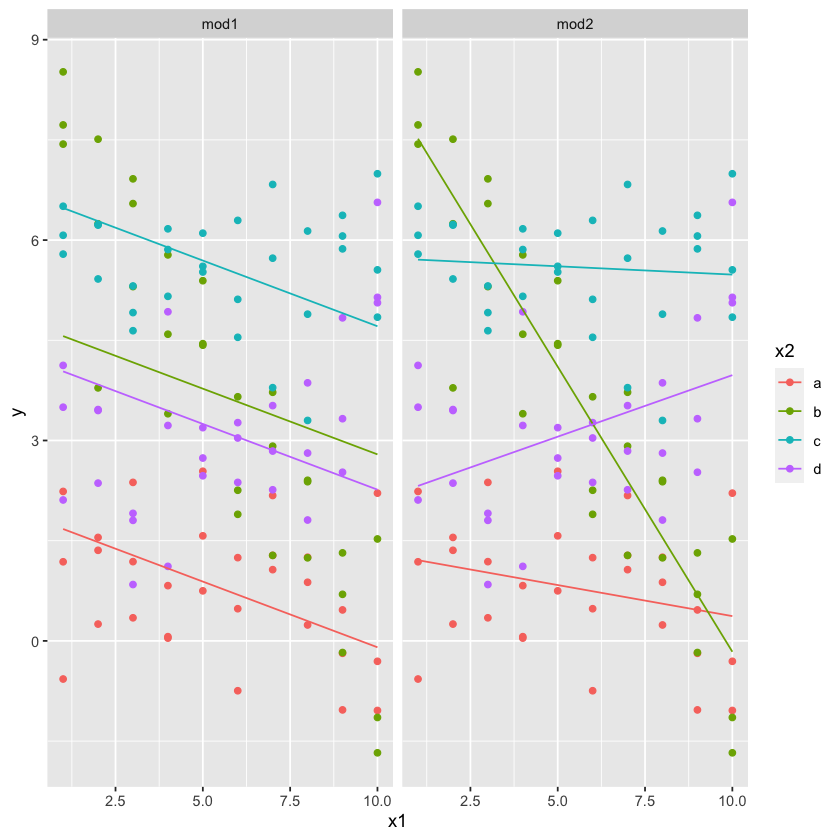

In [36]:
ggplot(sim3, aes(x1, y, color = x2)) +
geom_point() +
geom_line(data = grid, aes(y = pred)) +
facet_wrap(~ model)

`+`를 사용한 모델은 각 라인의 기울기는 같지만 y 절편값은 서로 다르다.<br>
`*`를 사용한 모델은 기울기와 y 절편값이 모두 다르다.<br>
어떤 모델이 이 데이터에 잘 맞을까? 이는 잔차를 통해 확인할 수 있다. 여기서는 각 그룹 내의 패턴을 쉽게 확인하기 위해 모델과 x2로 면분할하였다.

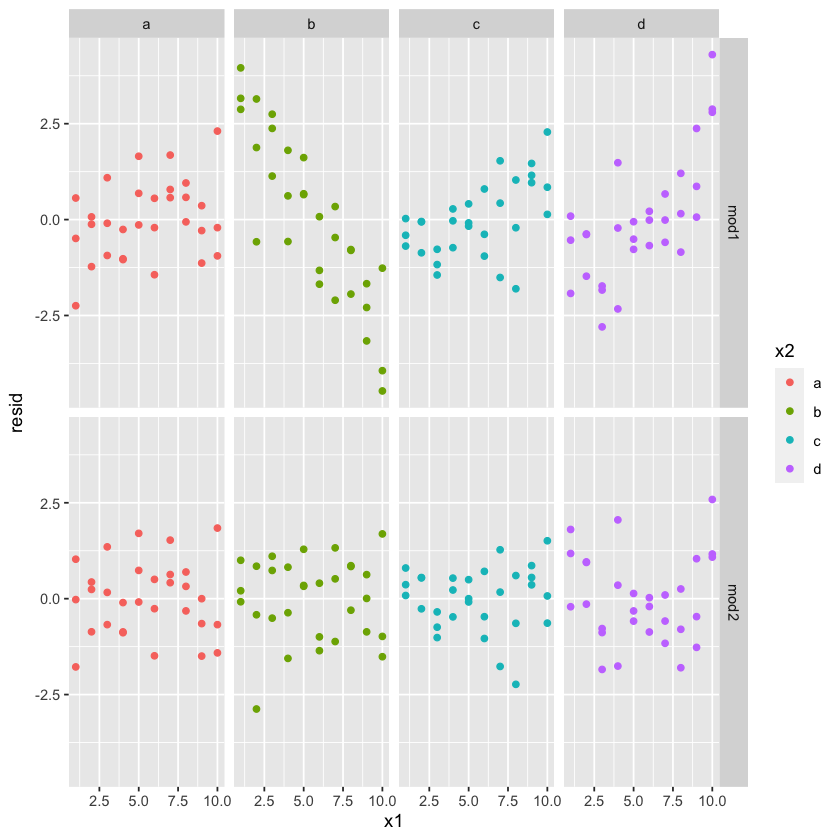

In [37]:
sim3 <- sim3 %>%
gather_residuals(mod1, mod2)

ggplot(sim3, aes(x1, resid, color = x2)) +
geom_point() +
facet_grid(model ~ x2)

mod의 잔차에서는 확실한 패턴이 거의 보이지 않는다. mod1의 잔차는 분명하게 모델이 b에서 어떤 패턴을 놓쳤다는 것을 나타내주며 
b보다는 덜하지만 c와 d에서도 여전히 패턴이 존재하는 것을 알 수 있다.

#### 연속형 변수의 상호작용

- 두개의 연속 변수로 이루어진 같은 모델로 시작한다.

In [38]:
mod1 <- lm(y ~ x1 + x2, data = sim4)
mod2 <- lm(y ~ x1 * x2, data = sim4)

In [39]:
grid <- sim4 %>%
data_grid(
    x1 = seq_range(x1, 5),
    x2 = seq_range(x2, 5)
    ) %>%
gather_predictions(mod1, mod2)

grid %>% head

model,x1,x2,pred
<chr>,<dbl>,<dbl>,<dbl>
mod1,-1.0,-1.0,0.9963094
mod1,-1.0,-0.5,-0.3949484
mod1,-1.0,0.0,-1.7862061
mod1,-1.0,0.5,-3.1774639
mod1,-1.0,1.0,-4.5687216
mod1,-0.5,-1.0,1.9071424


`seq_range` : 최소값과 최대값 사이를 균일하게 간격을 나눈다.

`-` 예시

In [40]:
seq_range(c(1,2),5)

[1] 1.00 1.25 1.50 1.75 2.00

`-` `seq_range` 옵션<br>
n은 안써도 됨, pretty = TRUE는 사람이 보기 좋게 만들어 줌(소수점 잘라서)                  

In [41]:
seq_range(c(0.0123, 0.923423), n = 5)

[1] 0.0123000 0.2400808 0.4678615 0.6956423 0.9234230

In [42]:
seq_range(c(0.0123, 0.923423), n = 5, pretty = TRUE)

[1] 0.0 0.2 0.4 0.6 0.8 1.0

`rcauchy` : 코시분포 난수 생성<br>
코시분포 : 모평균이 존재하지 않는 분포

In [43]:
x1 <- rcauchy(100)
seq_range(x1, n = 5)

[1] -30.6598728 -20.2891778  -9.9184828   0.4522122  10.8229071

`trim = 0.10` : 꼬리 값 10% 제거<br>
변수가 꼬리가 긴 분포를 갖고 있고 중심 근처의 값을 생성하고자 할 때 사용

In [44]:
seq_range(x1, n = 5, trim = 0.10)

[1] -8.3814313 -5.3006426 -2.2198540  0.8609347  3.9417233

`expnad = 0.1` : `trim()`과 반대 기능, 범위를 10% 확장

In [45]:
x2 <- c(0, 1)
seq_range(x2, n = 5)

[1] 0.00 0.25 0.50 0.75 1.00

In [46]:
seq_range(x2, n = 5, expand = 0.10)

[1] -0.050  0.225  0.500  0.775  1.050

`geom_tile` : 히트맵 찍기

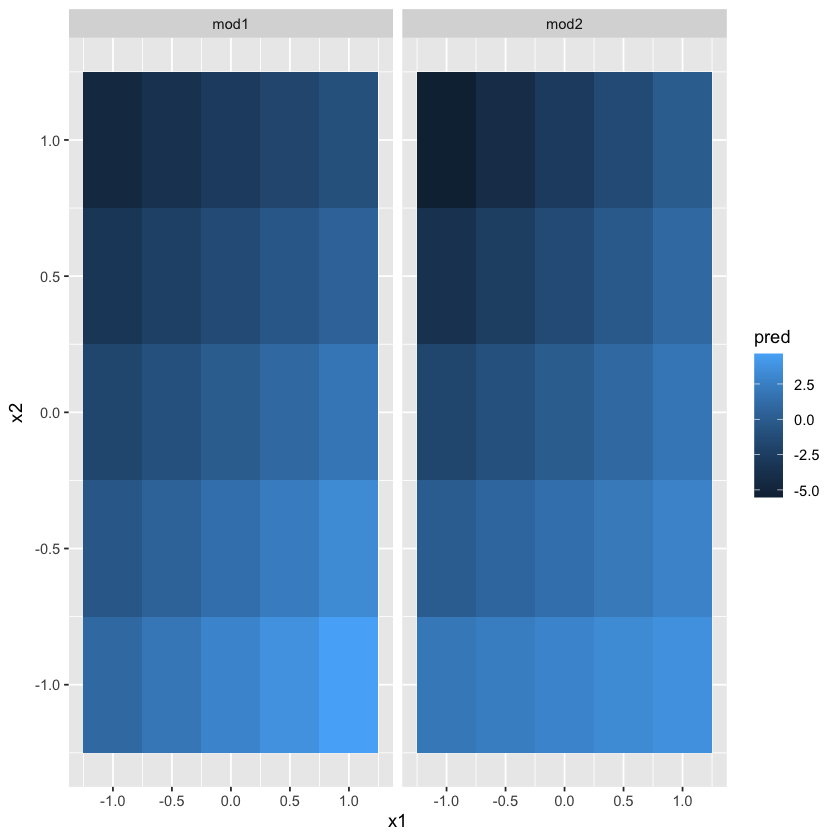

In [47]:
ggplot(grid, aes(x1, x2)) +
geom_tile(aes(fill = pred)) +
facet_wrap(~ model)

- 위의 모습으로만 보면 덧셈을 사용한 모델과 곱을 사용한 모델에 별 차이가 없어 보인다.

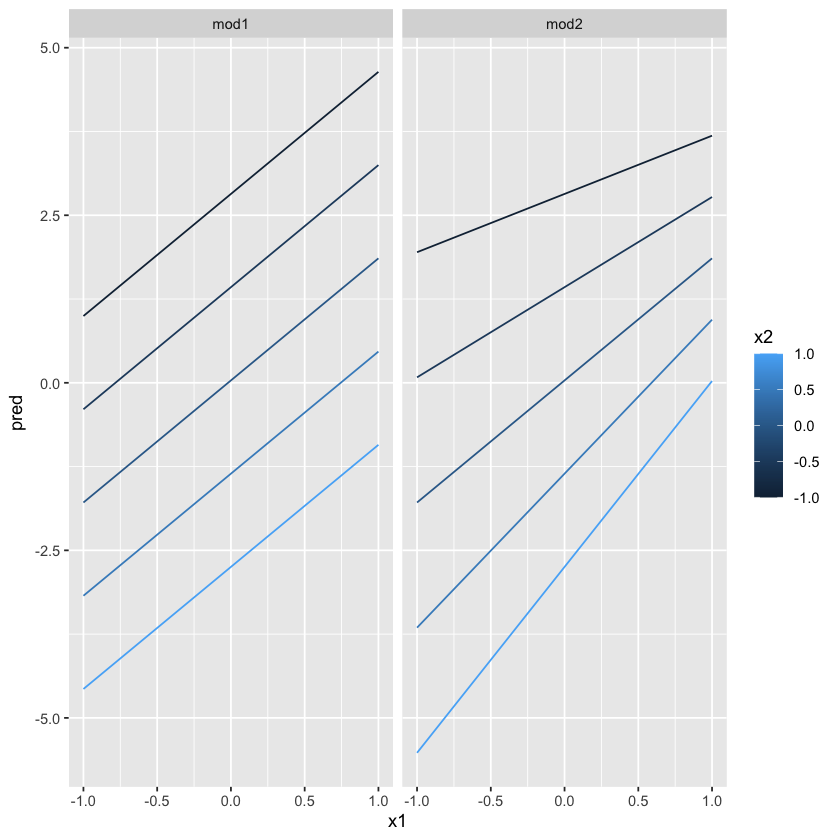

In [48]:
ggplot(grid, aes(x1, pred, color = x2, group = x2)) +
geom_line() +
facet_wrap(~ model)

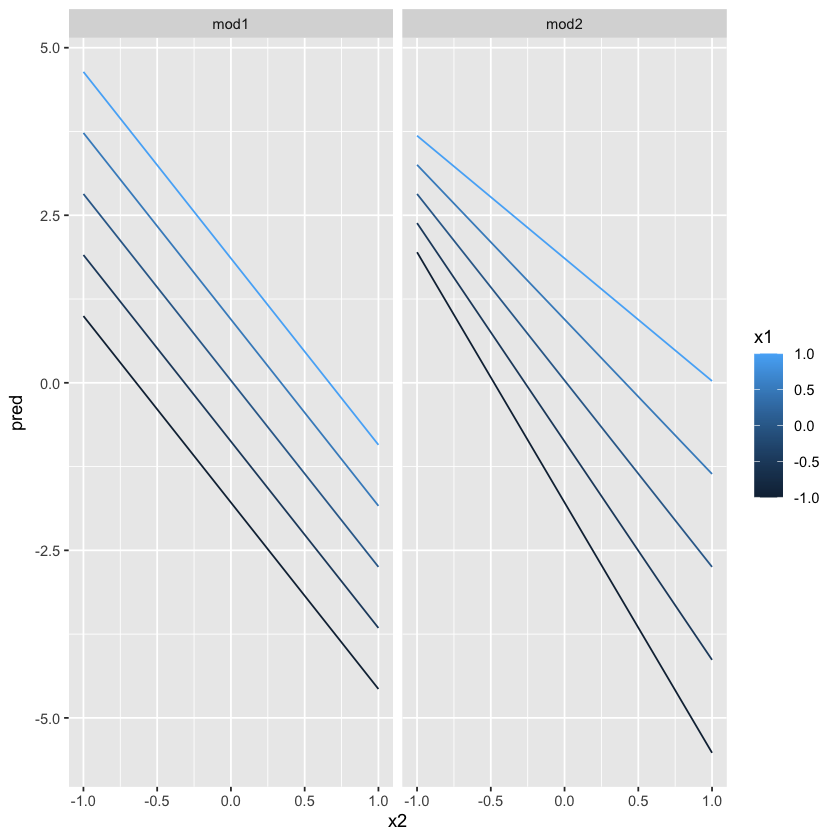

In [49]:
ggplot(grid, aes(x2, pred, color = x1, group = x1)) +
geom_line() +
facet_wrap(~ model)

위 플롯은 두 개의 연속 변수 사이의 상호작용이 기본적으로 범주형과 연속형 변수의 상호작용과 같은 방식으로 동작함을 보여준다.<br>
또한 이 플롯에서의 상호작용은 고정된 오프셋이 없다는 것을 나타낸다. 즉, y를 예측하기 위해서는 x1과 x2를 동시에 고려해야 한다.

### 변환(★★★)

- 추후 보강함(좀 어려움)<br>
지금은 옮겨 적는 것 위주로

모델이 변환되는 방식이 헷갈린다면 `model_matrix()`를 사용하여 `lm()`이 모델을 적합하는 수식이 무엇인지 정확하게 확인할 수 있다. 

In [50]:
df <- tribble(
    ~y, ~x,
    1,1,
    2,2,
    3,3
    )

model_matrix(df, y ~ x^2 + x)

(Intercept),x
<dbl>,<dbl>
1,1
1,2
1,3


In [51]:
model_matrix(df, y ~ I(x^2) + x)

(Intercept),I(x^2),x
<dbl>,<dbl>,<dbl>
1,1,1
1,4,2
1,9,3


변환은 비선형 함수를 근사하는 데 유용하게 사용할 수 있다. 미적분에서의 '어떤 평활 함수도 다항식의 무한한 합으로 근사시킬 수 있다'라는 테일러 정리처럼
$y = a_1 + a_2 * x + a_3 * x^2 + a_4 * x ^3$과 같은 방정식을 적합하여 선형 함수를 임의의 평활함수에 가깝게 만들 수 있다는 것을 의미한다.<br>
손으로 시퀀스를 타이핑하는 것은 번거롭기 때문에 R에서는 도우미 함수인 `poly()`를 사용할 수 있다.

In [52]:
model_matrix(df, y ~ poly(x, 2))

(Intercept),"poly(x, 2)1","poly(x, 2)2"
<dbl>,<dbl>,<dbl>
1,-7.071068e-01,0.4082483
1,-7.850462e-17,-0.8164966
1,7.071068e-01,0.4082483


그러나 `poly()`를 사용하는 데는 한 가지 주요한 문제가 있다. 데이터의 범위를 벗어나면 다항식은 급격하게 양의 무한대 또는 음의 무한대로 발산하게 된다.<br>
한 가지 안전한 대안은 본연의 스플라인(spline, 매끄러운 곡선)인 `splines::ns()`를 사용하는 것이다.

In [53]:
library('splines')

In [54]:
model_matrix(df, y ~ ns(x, 2))

(Intercept),"ns(x, 2)1","ns(x, 2)2"
<dbl>,<dbl>,<dbl>
1,0.0000000,0.0000000
1,0.5662628,-0.2108419
1,0.3440969,0.7706021


- 비선형 함수를 근사할 때 어떻게 표현되는지 살펴보자

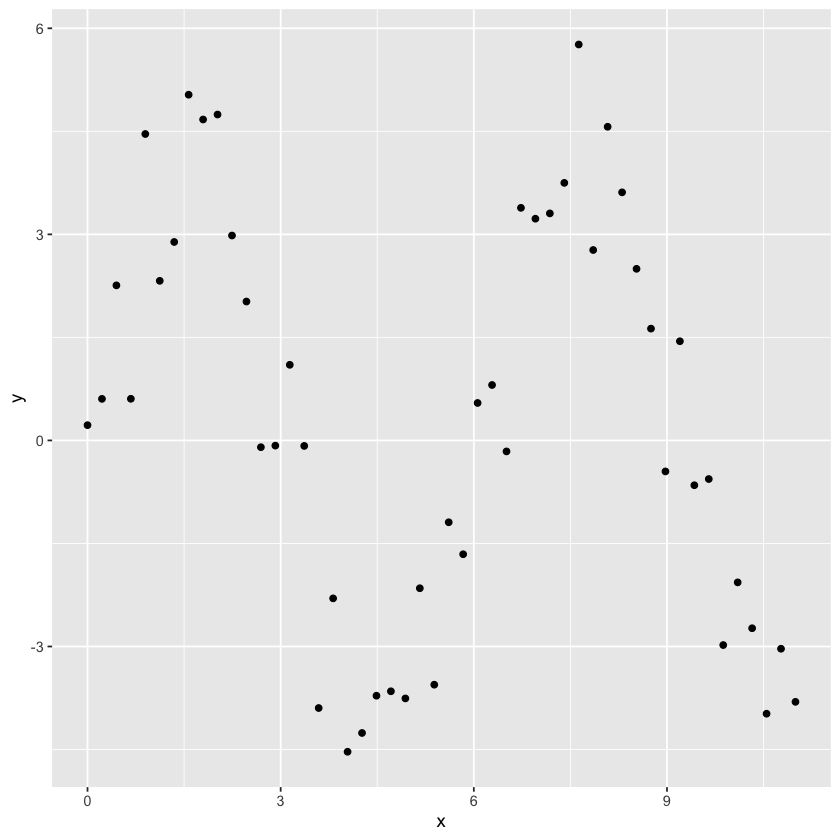

In [55]:
sim5 <- tibble(
    x = seq(0, 3.5 * pi, length = 50),
    y = 4 * sin(x) + rnorm(length(x))
    )
ggplot(sim5, aes(x, y)) +
geom_point()

- 이 데이터에 다섯 가지 모델을 적용해볼 것이다.

In [56]:
mod1 <- lm(y ~ ns(x, 1), data = sim5)
mod2 <- lm(y ~ ns(x, 2), data = sim5)
mod3 <- lm(y ~ ns(x, 3), data = sim5)
mod4 <- lm(y ~ ns(x, 4), data = sim5)
mod5 <- lm(y ~ ns(x, 5), data = sim5)

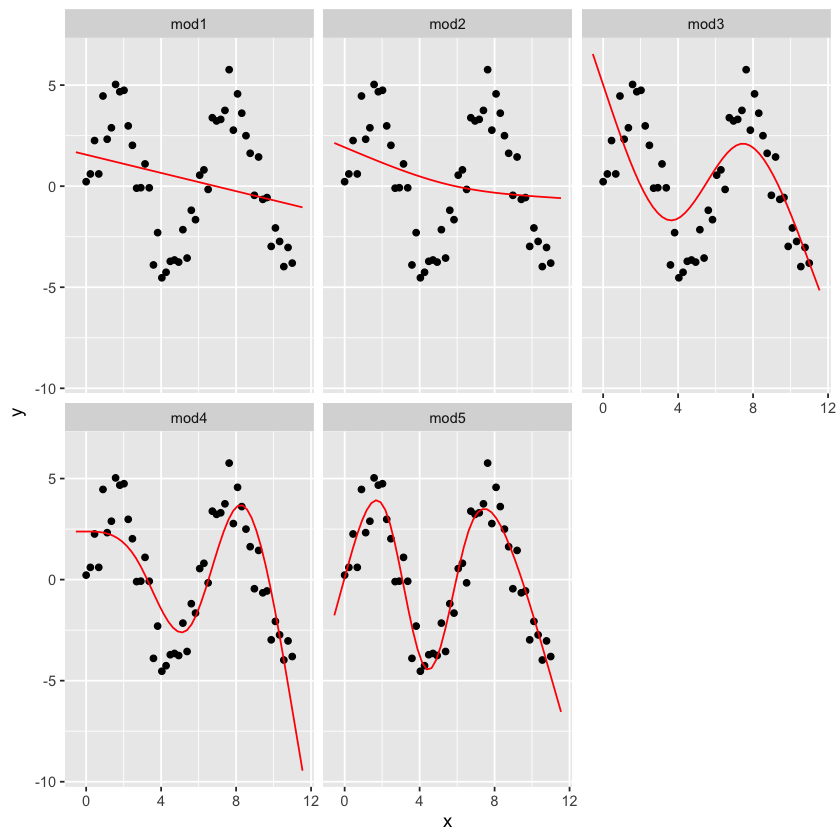

In [57]:
grid <- sim5 %>%
data_grid(x = seq_range(x, n = 50, expand = 0.1)) %>%
gather_predictions(mod1, mod2, mod3, mod4, mod4, mod5, .pred = "y")

ggplot(sim5, aes(x, y)) +
geom_point() +
geom_line(data = grid, color = "red") +
facet_wrap(~ model)

### 결측값

In [58]:
df <- tribble(
    ~x, ~y,
    1, 2.2,
    2, NA,
    3, 3.5,
    4, 8.3,
    NA, 10
    )

mod <- lm(y ~ x, data = df)

## 다른 모델 모음(후에 추가(★))

일반화 선형 모형<br>
일반화 가법 모형<br>
벌점 선형 모형<br>
로버스트 선형 모형<br>
트리 모형